In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')


In [2]:
train_dir = "C:/Users/Administrator/Desktop/eyedataset/dataset"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(256, 256),
    seed=42,
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [3]:
class_names = sorted(os.listdir(train_dir))

print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of Classes: 4


In [4]:
def visualize_images(path, target_size=(256, 256), num_images=5):

    
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    
    for i, image_filename in enumerate(selected_images):
        
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)

        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  

    
    plt.tight_layout()
    plt.show()

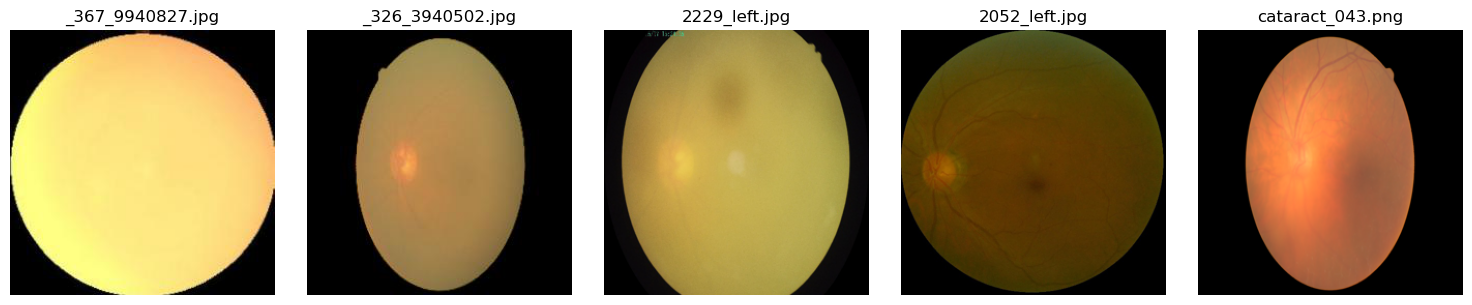

In [5]:

path_to_visualize = "C:/Users/Administrator/Desktop/eyedataset/dataset/cataract"
visualize_images(path_to_visualize, num_images=5)

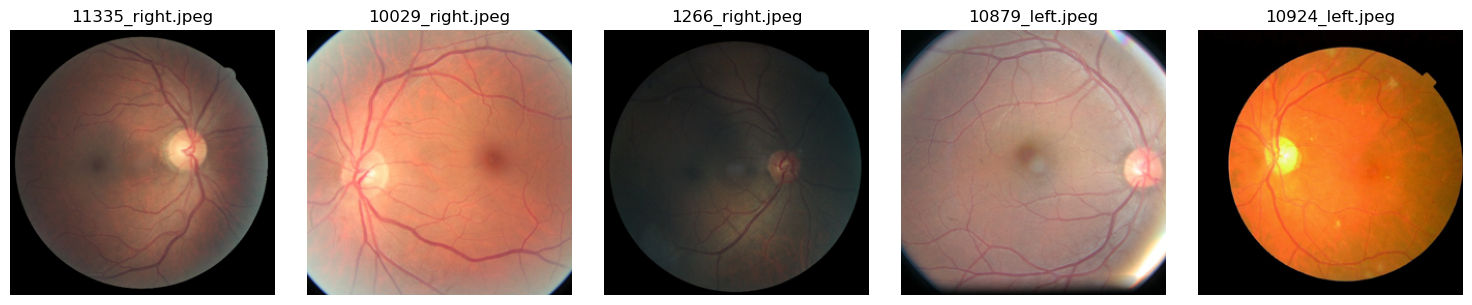

In [6]:

path_to_visualize ="C:/Users/Administrator/Desktop/eyedataset/dataset/diabetic_retinopathy"
visualize_images(path_to_visualize, num_images=5)

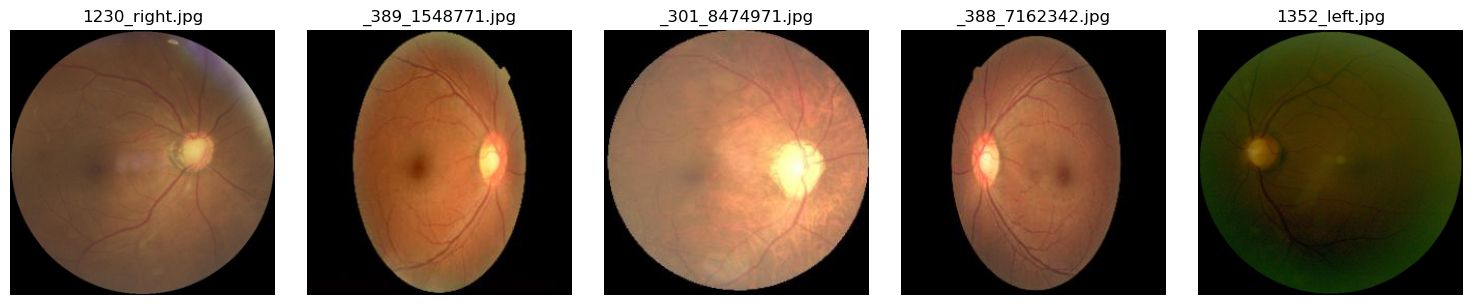

In [7]:

path_to_visualize = "C:/Users/Administrator/Desktop/eyedataset/dataset/glaucoma"
visualize_images(path_to_visualize, num_images=5)

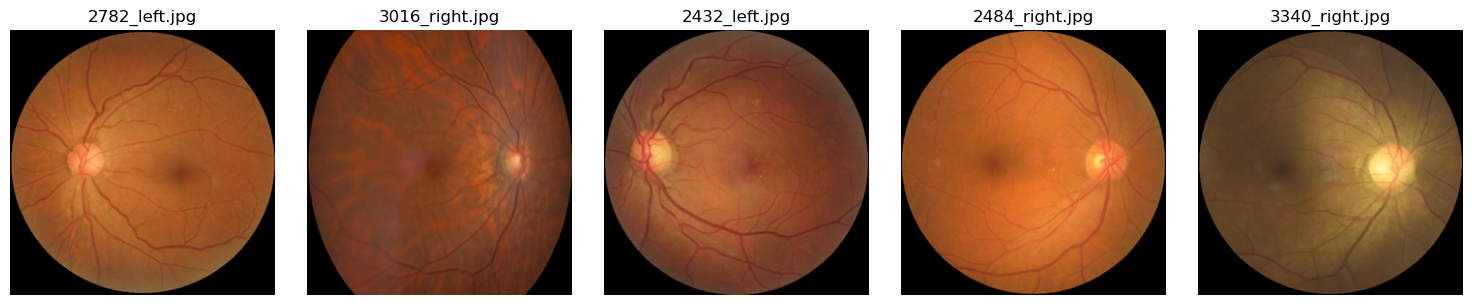

In [8]:

path_to_visualize = "C:/Users/Administrator/Desktop/eyedataset/dataset/normal"
visualize_images(path_to_visualize, num_images=5)

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.5)
])

In [11]:


base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))


In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [14]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:

base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 128, 128, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 128, 128, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 128, 128, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 128, 128, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 128, 128, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 128, 128, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 128, 128, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 128, 128, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 128, 128, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 128, 128, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 128, 128, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 129, 129, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 64, 64, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:

early_stopping = callbacks.EarlyStopping(patience=3)


history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping]  
)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.2985 - loss: 1.7327 - val_accuracy: 0.4650 - val_loss: 1.0992
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5352 - loss: 1.0670 - val_accuracy: 0.6524 - val_loss: 0.8542
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6569 - loss: 0.8674 - val_accuracy: 0.7117 - val_loss: 0.7496
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6950 - loss: 0.7562 - val_accuracy: 0.7414 - val_loss: 0.6886
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7183 - loss: 0.7047 - val_accuracy: 0.7544 - val_loss: 0.6551
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7184 - loss: 0.6591 - val_accuracy: 0.7592 - val_loss: 0.6322
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7559 - loss: 0.6193 - val_accuracy: 0.7782 - val_loss: 0.6161
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7560 - loss: 0.5813 - val_accu

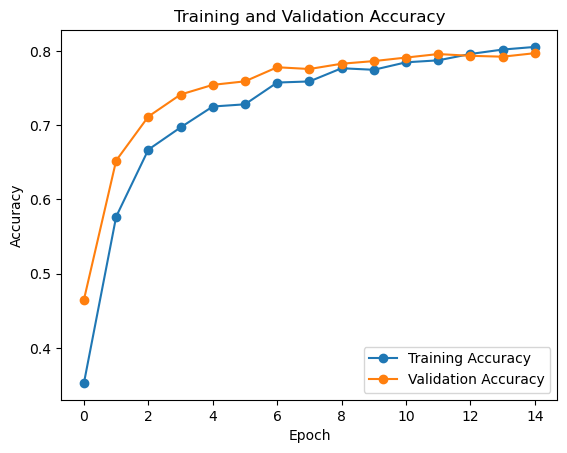

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

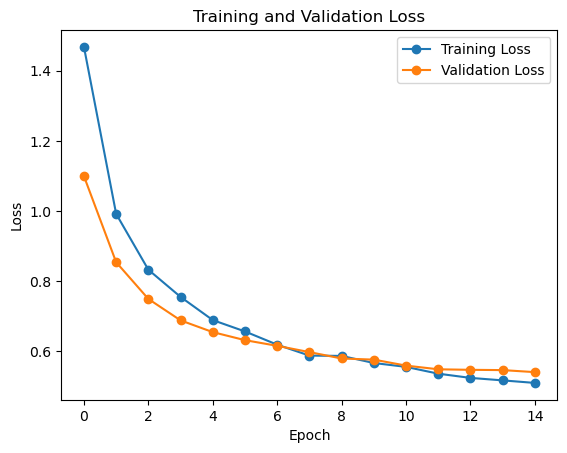

In [20]:

# Plot training history
plt.plot(history.history['loss'], label='Training Loss',marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss',marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

In [31]:

model.save("eye_disease_model.keras")



In [32]:
from tensorflow.keras.models import load_model

model = load_model("eye_disease_model.keras")


first image to predict
actual label: glaucoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predicted label: glaucoma


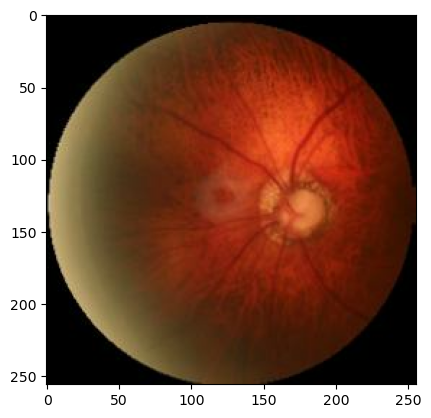

In [33]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


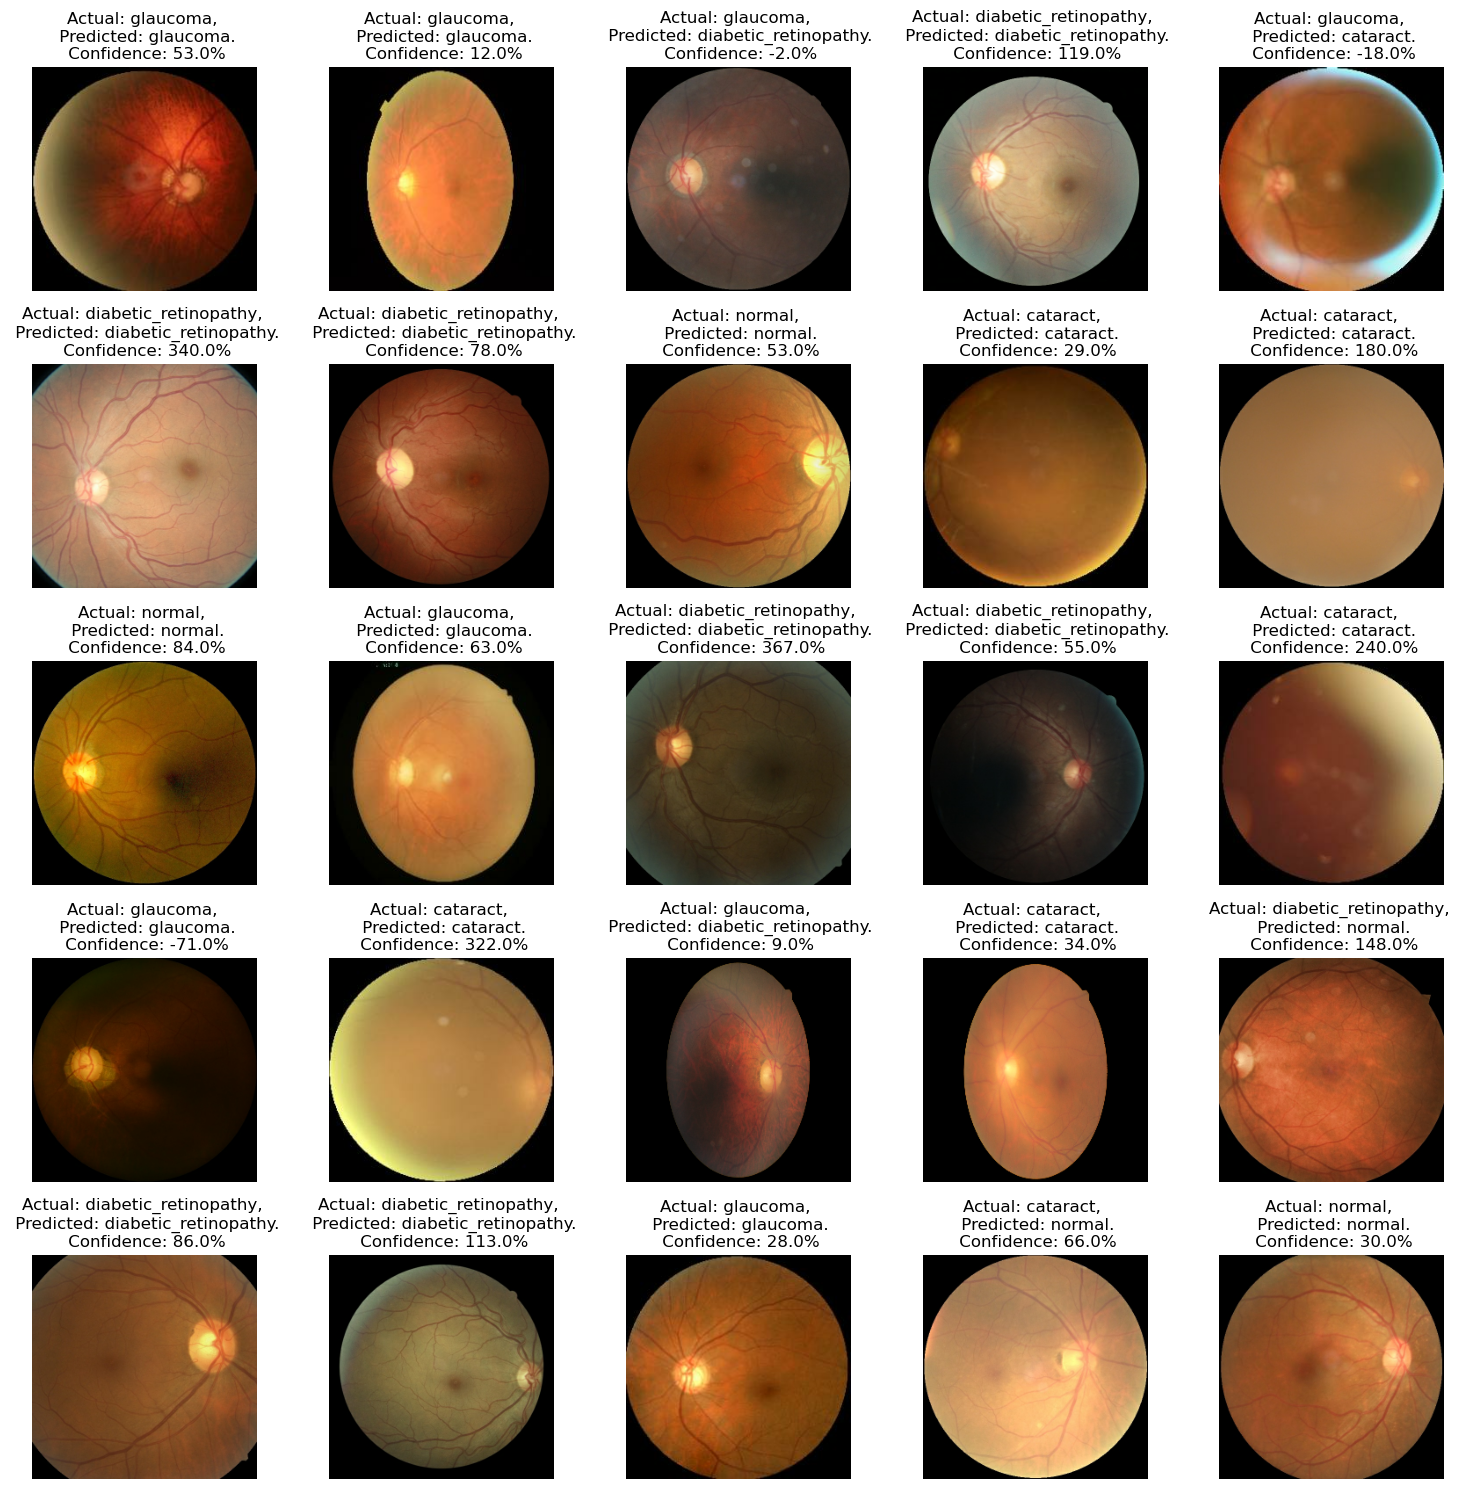

In [27]:

plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)  # Adjust the subplot layout as per your preference
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

plt.tight_layout()
plt.show()

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 852ms/step


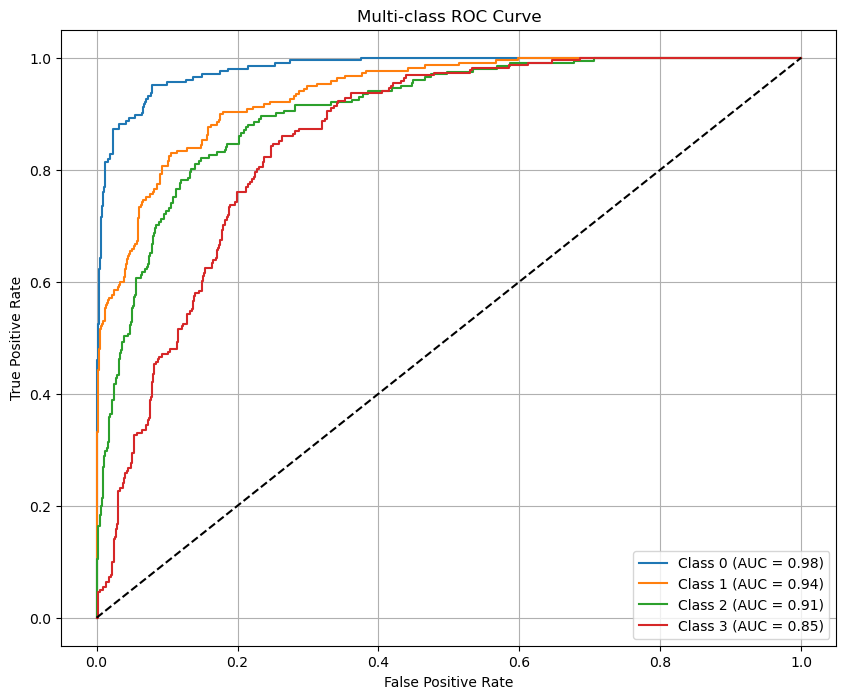

In [42]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model("eye_disease_model.keras")

train_dir = "C:/Users/Administrator/Desktop/eyedataset/dataset"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(256, 256),
    seed=42,
)


X_val = []
y_val = []

for images, labels in val_ds:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())


X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)


y_score = model.predict(X_val)


n_classes = y_score.shape[1]
y_val_bin = label_binarize(y_val, classes=range(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

<Figure size 800x600 with 0 Axes>

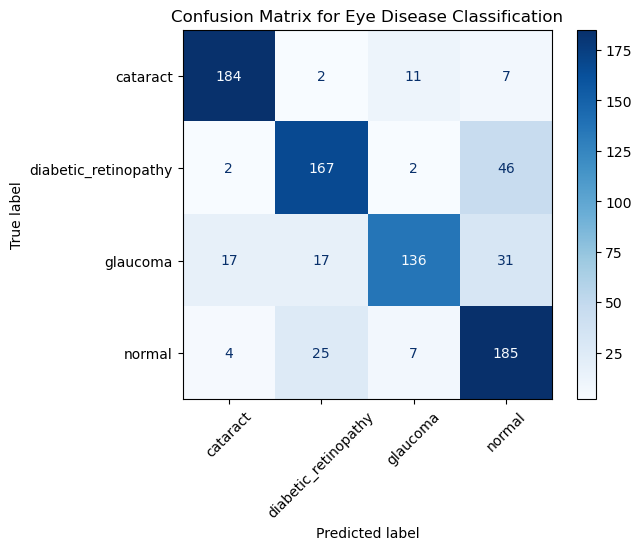

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = tf.keras.models.load_model("eye_disease_model.keras")

class_names = val_ds.class_names
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Eye Disease Classification")
plt.show()


In [41]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf


model = tf.keras.models.load_model("eye_disease_model.keras")


y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


class_names = val_ds.class_names


report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 